# Name
Tyler Caplinger

# Hypothesis
Accounts that focus on technology topics have a high number of followers.

# Theoretical Rationale
Technology is a popular topic on social media because people are interested in new technology, software, and new things. This could raise followers for such accounts, based on concepts in research into social media activity.

# Statistical Application
I will use group comparison by collecting technology-related users and calculating the average followersCount. I could compare it to another group, but for now, I'll look at the numbers. Variables: followersCount, postsCount from profiles.

# Endpoint Plan
Endpoint 1: app.bsky.actor.searchActors

Request Parameters:

q: Set to “technology” to search for users interested in or related to technology.

limit: Set to 50 so the request returns up to 50 user profiles at once.

Response Fields:

actors: A list of user profiles that includes:

did: The user’s unique ID.

handle: The user’s Bluesky username.

displayName: The user’s display name.

Connection to Hypothesis:
The did is useful for retrieving more detailed info later, while handle and displayName help identify users actually related to technology (for example, users with “tech” or “AI” in their names).

Endpoint 2: app.bsky.actor.getProfile

Request Parameters:

actor: The user’s did (from Endpoint 1) to get their full profile.

Response Fields:

did: The user’s unique ID.

handle: The user’s Bluesky username.

displayName: The user’s name.

followersCount: How many people follow the user.

followsCount: How many accounts they follow.

postsCount: Total posts they’ve made.

createdAt: When their account was created.

description: The user’s bio.

Connection to Hypothesis:
The followersCount is the main variable to test whether tech related users tend to have more followers. The description can confirm if the profile is actually about technology (mentioning things like coding, AI, or software).

# Reliability and Bias
The data is reliable because it's from the official API, but may be biased towards popular users since search might prioritize them. Missing fields if users don't have descriptions.

# Limitations
Follower counts may not be real-time, some fields like postsCount may not always be accurate or up-to-date.

# Data Collection

# Data Collection (Endpoint 1): 

In [95]:
# imports
import requests 
import time
import json as js
import pandas as pd

BASE_URL = "https://public.api.bsky.app/xrpc"

In [96]:
endpoint = f"{BASE_URL}/app.bsky.actor.searchActors"
params = {
    "q": "technology",
    "limit": 50  # To get more data
}

resp = requests.get(endpoint, params=params, headers=headers, timeout=30)

print("Status:", resp.status_code)

data = resp.json()

print("Top-level keys:", list(data.keys()))

Status: 200
Top-level keys: ['actors', 'cursor']


In [97]:
## Flatten the actors
rows = []
for p in actors:
    stats = {
        "creator_did": p.get("did"),
        "creator_handle": p.get("handle"),
        "creator_displayName": p.get("displayName"),
    }
    rows.append(stats)
posts_df = pd.DataFrame(rows)
posts_df.head(5)

,creator_did,creator_handle,creator_displayName
0,did:plc:ewvi7nxzyoun6zhxrhs64oiz,atproto.com,AT Protocol Developers
1,did:plc:qiknc4t5rq7yngvz7g4aezq7,faineg.bsky.social,Faine Greenwood
2,did:plc:vcepp6trx4vpe5ourxso4tjl,404media.co,404 Media
3,did:plc:dr6cavavqbbtzeknnl76tp54,techconnectify.bsky.social,Technology Connections
4,did:plc:vtpyqvwce4x6gpa5dcizqecy,techcrunch.com,TechCrunch


# Data Collection (Endpoint 2):

In [98]:
unique_dids = posts_df["creator_did"].dropna().unique().tolist()

all_profiles = []
for d in unique_dids:
    params = []
    params.append(("actor", d))
    r = requests.get(f"{BASE_URL}/app.bsky.actor.getProfile", params=params, timeout=30)
    data = r.json()

    all_profiles.append({
        "did": data.get("did"),
        "handle": data.get("handle"),
        "displayName": data.get("displayName"),
        "followersCount": data.get("followersCount"),
        "followsCount": data.get("followsCount"),
        "postsCount": data.get("postsCount"),
        "createdAt": data.get("createdAt"),
        "description": data.get("description"),
    })

all_profiles_df = pd.DataFrame(all_profiles)
all_profiles_df.head(5)

,did,handle,displayName,followersCount,followsCount,postsCount,createdAt,description
0,did:plc:ewvi7nxzyoun6zhxrhs64oiz,atproto.com,AT Protocol Developers,114145,21,148,2023-04-26T06:19:25.508Z,Social networking technology created by Bluesk...
1,did:plc:qiknc4t5rq7yngvz7g4aezq7,faineg.bsky.social,Faine Greenwood,91782,19804,105470,2023-04-10T23:37:13.710Z,civilian drone mapping technology and GIS/spat...
2,did:plc:vcepp6trx4vpe5ourxso4tjl,404media.co,404 Media,135670,164,1087,2023-08-21T15:29:50.454Z,"it's a website (and a podcast, and a newslette..."
3,did:plc:dr6cavavqbbtzeknnl76tp54,techconnectify.bsky.social,Technology Connections,173819,421,10548,2023-11-18T22:50:02.480Z,I'm that YouTuber who taught you how dishwashe...
4,did:plc:vtpyqvwce4x6gpa5dcizqecy,techcrunch.com,TechCrunch,168713,39,14239,2023-04-26T17:53:51.327Z,Technology news and analysis with a focus on f...


# Build DataFrames

In [99]:
# merge joins rows from the two dataframes
posts_enriched = posts_df.merge(
    all_profiles_df.add_prefix("author_"),
    left_on="creator_did",
    right_on="author_did",
    how="left"
)

posts_enriched.head(5)

,creator_did,creator_handle,creator_displayName,author_did,author_handle,author_displayName,author_followersCount,author_followsCount,author_postsCount,author_createdAt,author_description
0,did:plc:ewvi7nxzyoun6zhxrhs64oiz,atproto.com,AT Protocol Developers,did:plc:ewvi7nxzyoun6zhxrhs64oiz,atproto.com,AT Protocol Developers,114145,21,148,2023-04-26T06:19:25.508Z,Social networking technology created by Bluesk...
1,did:plc:qiknc4t5rq7yngvz7g4aezq7,faineg.bsky.social,Faine Greenwood,did:plc:qiknc4t5rq7yngvz7g4aezq7,faineg.bsky.social,Faine Greenwood,91782,19804,105470,2023-04-10T23:37:13.710Z,civilian drone mapping technology and GIS/spat...
2,did:plc:vcepp6trx4vpe5ourxso4tjl,404media.co,404 Media,did:plc:vcepp6trx4vpe5ourxso4tjl,404media.co,404 Media,135670,164,1087,2023-08-21T15:29:50.454Z,"it's a website (and a podcast, and a newslette..."
3,did:plc:dr6cavavqbbtzeknnl76tp54,techconnectify.bsky.social,Technology Connections,did:plc:dr6cavavqbbtzeknnl76tp54,techconnectify.bsky.social,Technology Connections,173819,421,10548,2023-11-18T22:50:02.480Z,I'm that YouTuber who taught you how dishwashe...
4,did:plc:vtpyqvwce4x6gpa5dcizqecy,techcrunch.com,TechCrunch,did:plc:vtpyqvwce4x6gpa5dcizqecy,techcrunch.com,TechCrunch,168713,39,14239,2023-04-26T17:53:51.327Z,Technology news and analysis with a focus on f...


# Data Visualization
To visualize the relationship:

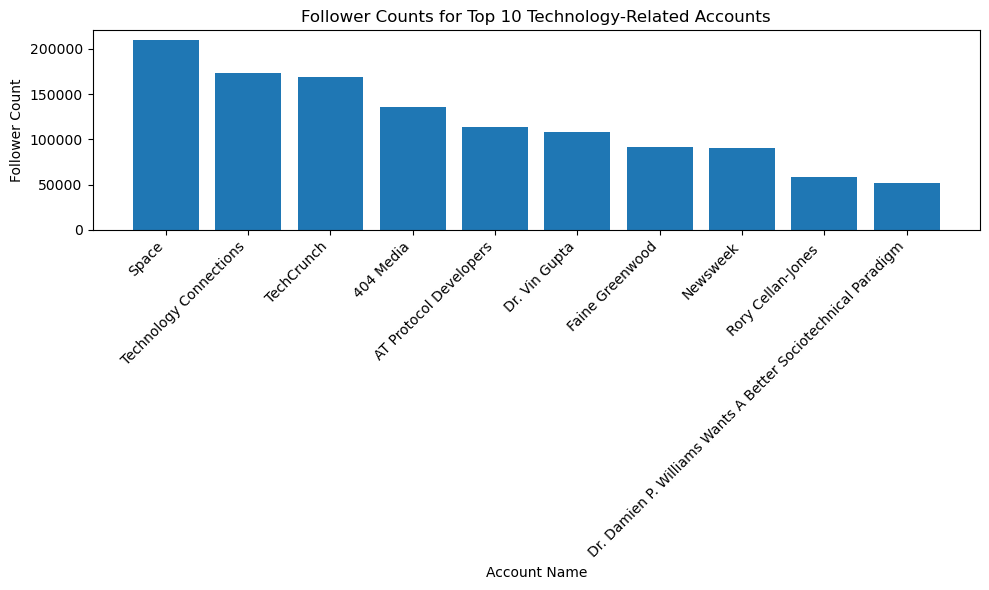

In [100]:
import matplotlib.pyplot as plt

# Select top 10 accounts by followers for clarity in visualization
top_accounts = posts_enriched.sort_values(by='author_followersCount', ascending=False).head(10)

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_accounts['author_displayName'], top_accounts['author_followersCount'])
plt.xlabel('Account Name')
plt.ylabel('Follower Count')
plt.title('Follower Counts for Top 10 Technology-Related Accounts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()

# Conclusion
From the data, I see that technology accounts like AT Protocol Developers have over 100,000 followers. This supports my hypothesis that technology accounts have high follower counts. Challenges were getting the API to work, I had to change the base URL to public.